
# <span style="color:rgb(213,80,0)">Discrete Variable Tutorial</span>

**Sean Osis, Allan Brett, Reed Ferber, Reginaldo Fukuchi, Blayne Hettinga**


### Purpose

The purpose of this tutorial is to demonstrate loading JSON data files, the CSV metadata and a simple analysis of discrete variables to examine fundamental principles of human locomotion.


**Requirements**

-  MATLAB 2016a or later and a supported OS
-  MATLAB Statistics and Machine Learning Toolbox
-  Code package included with supplemental material
-  Open access data set included with supplemental material
### Load Data

In this section, data are loaded from files that have been included with this project. Individual subject kinematics are included in the JSON files, while the metadata are tabulated for all subjects in the CSV files.


In [1]:
% Point to the data folders
% Modify these directories as required
jsondir = '../Output_folder/reformat_data';
csvdir  = '../Output_folder';

% Obtain list of JSONs
jsons = dir(fullfile(jsondir, '/*/*.json'));
csvs  = dir(fullfile(csvdir, '*.csv'));

jsons(1)

ans = struct with fields:
       name: '20110531T161051.json'
eformat_data\100001'
       date: '08-Mar-2023 12:48:00'
      bytes: 7244825
      isdir: 0
    datenum: 7.3895e+05

In [2]:
csvs(1)

ans = struct with fields:
       name: 'run_data_meta.csv'
     folder: 'Z:\Figshare Project\Output_folder'
       date: '02-May-2023 08:45:28'
      bytes: 389279
      isdir: 0
    datenum: 7.3901e+05

In [3]:
% Load CSVs and extract required variables

% Instantiate variables
variables = [["sub_id", "int64"]; ...
             ["json_file", "string"]; ...
             ["height_m", "double"]; ...
                ["speed_m_s^-1", "double"]; ...
              ["left_stride_m", "double"]; ...
             ["right_stride_m", "double"]; ...
             ["left_stride_hz", "double"]; ...
             ["right_stride_hz", "double"]]

variables = 8x2 string
"sub_id"       "int64"     
"json_file"    "string"    
"height_m"     "double"    
"speed_m_s^-1" "double"    
"left_stride_m""double"    
"right_strid…  "double"    
"left_stride…  "double"    
"right_strid…  "double"

In [4]:

% Create empty table
datatable = table('Size',[0,size(variables,1)],...
                  'VariableNames', variables(:,1),...
                  'VariableTypes', variables(:,2));

csv_ = cell(length(csvs),1);
for i = 1:length(csvs)
    csv_{i} = readtable(fullfile(csvs(i).folder, csvs(i).name));
    if contains(csvs(i).name, 'run')
       csv_{i}.gaitspeed = csv_{i}.speed_r;
       csv_{i}.gaittype(:)  = "run";
       csv_{i}.speed_r = [];
    else
       csv_{i}.gaitspeed = csv_{i}.speed_w;
       csv_{i}.gaittype(:)  = "walk";
       csv_{i}.speed_w = [];
    end
end

csv_ = vertcat(csv_{:});

csv_ = csv_(:, {'sub_id','datestring','filename','Height','gaitspeed','gaittype'});

size(csv_)

ans = 1x2
        3920           6

In [5]:
% Load JSONs and extract stride discrete variables

left_stride_m   = cell(height(csv_),1);
right_stride_m  = left_stride_m;
left_stride_hz  = left_stride_m;
right_stride_hz = left_stride_m;

% Set state for reproducibility
rng(20);

s = 1000;
samp = randi(height(csv_),s,1); % Randomly sample 1000 subjects

for i = 1:s

    json_file = fullfile(jsondir, num2str(csv_.sub_id(samp(i))), csv_.filename{samp(i)});

    fid = fopen(json_file);
    raw = fread(fid,inf);
    str = char(raw');
    fclose(fid);
    out = jsondecode(str);

    if csv_.gaittype{samp(i)} == "run"

        left_stride_m{samp(i)}   = out.dv_r.left.STRIDE_LENGTH;
        right_stride_m{samp(i)}  = out.dv_r.right.STRIDE_LENGTH;
        left_stride_hz{samp(i)}  = out.dv_r.left.STRIDE_RATE;
        right_stride_hz{samp(i)} = out.dv_r.right.STRIDE_RATE;

    else

        left_stride_m{samp(i)}   = out.dv_w.left.STRIDE_LENGTH;
        right_stride_m{samp(i)}  = out.dv_w.right.STRIDE_LENGTH;
        left_stride_hz{samp(i)}  = out.dv_w.left.STRIDE_RATE;
        right_stride_hz{samp(i)} = out.dv_w.right.STRIDE_RATE;

    end

    if mod(i,100) == 0
        disp(['Completed ' num2str(i/s*100,'%.1f') '% of files'])
    end

end

Completed 10.0% of files
Completed 20.0% of files
Completed 30.0% of files
Completed 40.0% of files
Completed 50.0% of files
Completed 60.0% of files
Completed 70.0% of files
Completed 80.0% of files
Completed 90.0% of files
Completed 100.0% of files

In [6]:

left_stride_m(cellfun(@isempty, left_stride_m))     = {nan};
left_stride_hz(cellfun(@isempty, left_stride_hz))   = {nan};

right_stride_m(cellfun(@isempty, right_stride_m))   = {nan};
right_stride_hz(cellfun(@isempty, right_stride_hz)) = {nan};

csv_.left_stride_m   = cell2mat(left_stride_m);
csv_.left_stride_hz  = cell2mat(left_stride_hz);

csv_.right_stride_m  = cell2mat(right_stride_m);
csv_.right_stride_hz = cell2mat(right_stride_hz);

csv_(1:5,:)



### Inspect and Clean Data

In this section, we examine the distribution of our variables and determine whether and how to clean out anomalous values.



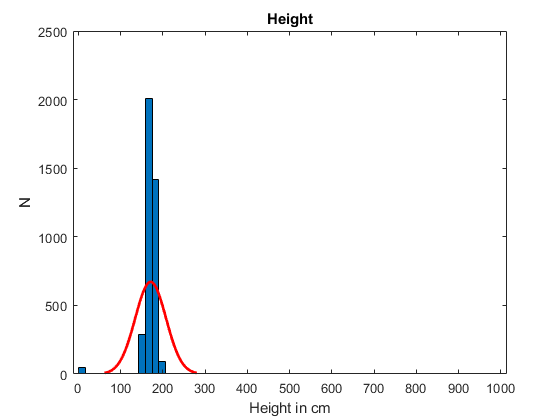

In [7]:
% Height

histfit(csv_.Height)
title('Height')
xlabel('Height in cm')
ylabel('N')

In [8]:

p = 0:0.1:1;

disp('Quantiles for Height')

Quantiles for Height

In [9]:
y = quantile(csv_.Height,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
         0  160.0000  163.5000  166.0000  169.0000  172.0000  174.2900  177.0000  180.0000  183.8000  999.0000


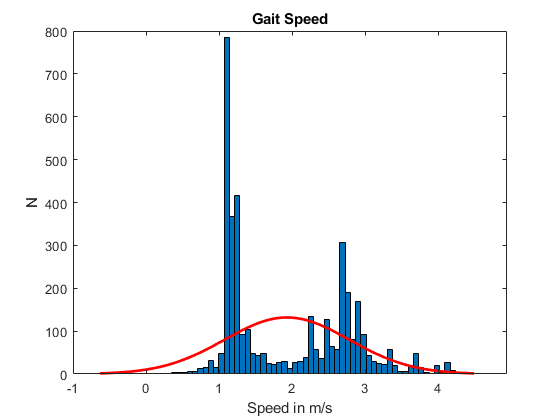

In [10]:
% Speed

histfit(csv_.gaitspeed)
title('Gait Speed')
xlabel('Speed in m/s')
ylabel('N')

In [11]:

p = 0:0.1:1;

disp('Quantiles for Speed')

Quantiles for Speed

In [12]:
y = quantile(csv_.gaitspeed,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
    0.3923    1.1163    1.1269    1.1751    1.2578    1.5073    2.2708    2.6730    2.7484    2.9694    4.8770


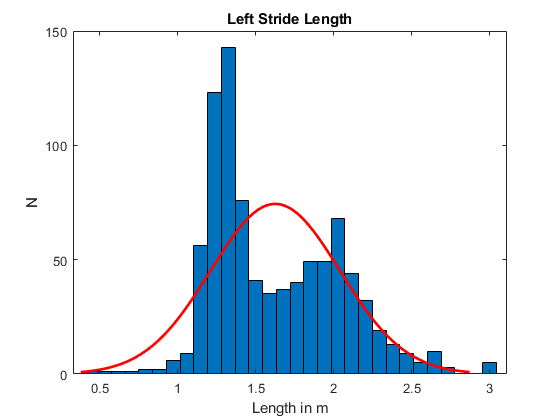

In [13]:
% Left Stride Length

histfit(csv_.left_stride_m)
title('Left Stride Length')
xlabel('Length in m')
ylabel('N')

In [14]:

p = 0:0.1:1;

disp('Quantiles for Stride Length')

Quantiles for Stride Length

In [15]:
y = quantile(csv_.left_stride_m,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
    0.4309    1.2027    1.2594    1.3085    1.3774    1.4943    1.7090    1.8849    2.0302    2.1787    3.0357


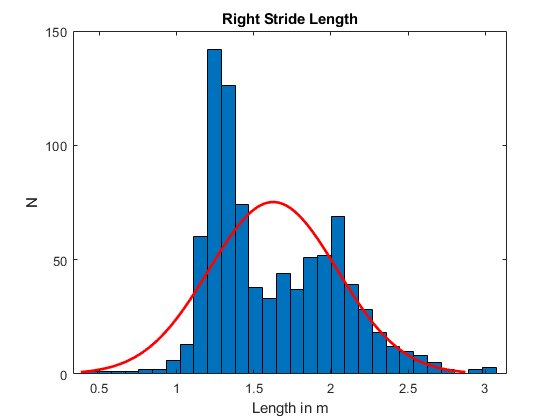

In [16]:
% Right Stride Length

histfit(csv_.right_stride_m)
title('Right Stride Length')
xlabel('Length in m')
ylabel('N')

In [17]:

p = 0:0.1:1;

disp('Quantiles for Stride Length')

Quantiles for Stride Length

In [18]:
y = quantile(csv_.right_stride_m,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
    0.4309    1.2020    1.2599    1.3116    1.3769    1.4935    1.7091    1.8839    2.0259    2.1799    3.0555


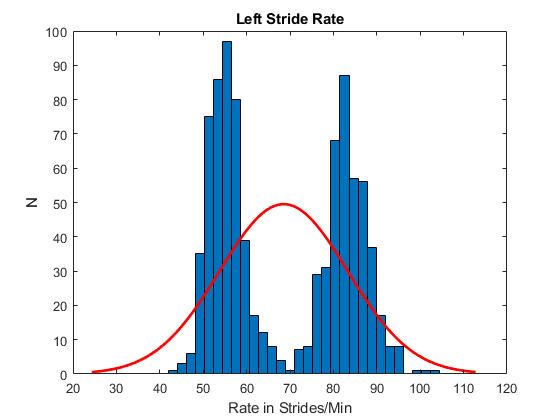

In [19]:
% Left Stride Rate

histfit(csv_.left_stride_hz)
title('Left Stride Rate')
xlabel('Rate in Strides/Min')
ylabel('N')

In [20]:

p = 0:0.1:1;

disp('Quantiles for Stride Rate')

Quantiles for Stride Rate

In [21]:
y = quantile(csv_.left_stride_hz,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
   43.6364   51.5581   53.8117   55.5993   57.6923   62.9926   78.4314   81.6327   83.9161   86.9565  104.3478


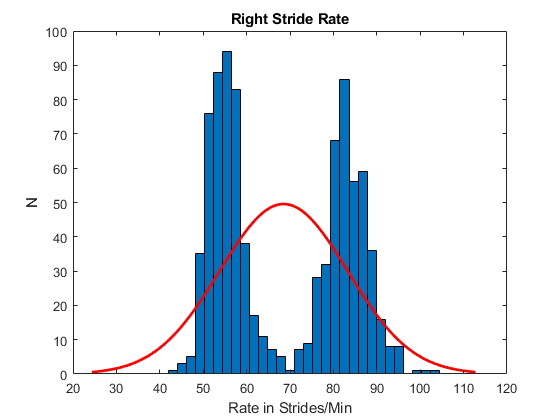

In [22]:
% Right Stride Rate

histfit(csv_.right_stride_hz)
title('Right Stride Rate')
xlabel('Rate in Strides/Min')
ylabel('N')

In [23]:

p = 0:0.1:1;

disp('Quantiles for Stride Rate')

Quantiles for Stride Rate

In [24]:
y = quantile(csv_.right_stride_hz,p);
disp([p;y])

         0    0.1000    0.2000    0.3000    0.4000    0.5000    0.6000    0.7000    0.8000    0.9000    1.0000
   43.7956   51.5021   53.8117   55.6848   57.6923   62.6636   78.4314   81.6327   83.9161   86.9565  104.3478

In [25]:
% Clean Height Values

csv_.Height(csv_.Height == 999) = nan;
csv_.Height(csv_.Height == 0) = nan;


### Plot Basic Variables

These plots establish fundamental aspects of human locomotion, relating gait speed, stride length, stride frequency, and body height.



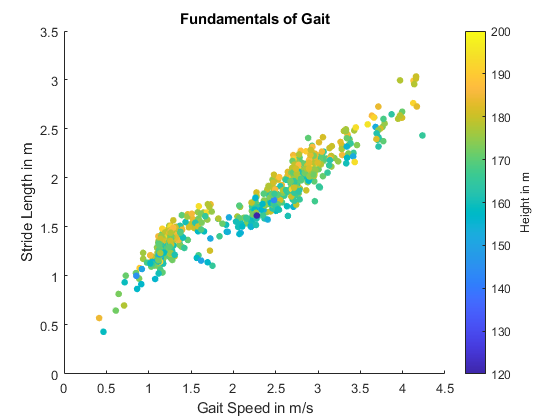

In [26]:
scatter(csv_.gaitspeed, csv_.left_stride_m, 25, csv_.Height, 'filled');
ax = gca;
title(ax, 'Fundamentals of Gait')
xlabel(ax, 'Gait Speed in m/s')
ylabel(ax, 'Stride Length in m')

a=colorbar;
ylabel(a, 'Height in m')


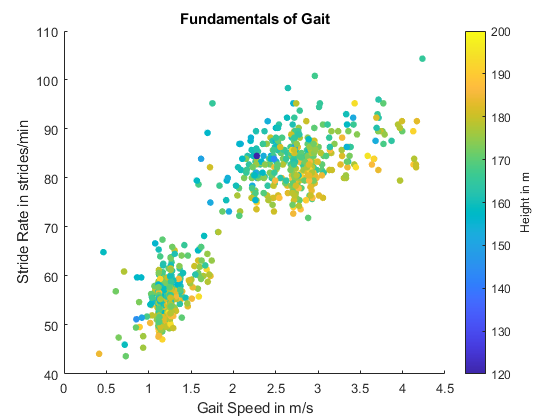

In [27]:
scatter(csv_.gaitspeed, csv_.left_stride_hz, 25, csv_.Height, 'filled');
ax = gca;
title(ax, 'Fundamentals of Gait')
xlabel(ax, 'Gait Speed in m/s')
ylabel(ax, 'Stride Rate in strides/min')

a=colorbar;
ylabel(a, 'Height in m')


### Interpretation

The fundamental plots of gait variables can be related to prior work in the field of gait biomechanics to interpret our findings.

-  There is clear clustering for both stride rate and stride length that correspond to established boundaries for the walk\-run transition at ~2 m/s of gait speed \[1\].
-  A highly linear relationship between gait speed and stride length for both walking and running, though slighly different for each \[2\].
-  For both stride rate and stride length, body height plays a subtle role in modifying the relationship with gait speed \[3\]. For stride length, taller individuals skew to slightly longer stride lengths.  For stride rate, taller individuals skew towards reduced stride rates.

### References

\[1\] Rotstein A, Inbar O, Berginsky T, Meckel Y.  Preferred transition speed between walking and running: effects of  training status. Med Sci Sports Exerc. 2005 Nov;37(11):1864\-70.


\[2\] Bailey, J., Mata, T., & Mercer, J. A. (2017). Is the Relationship  Between Stride Length, Frequency, and Velocity Influenced by Running on a Treadmill or Overground?. *International journal of exercise science*, *10*(7), 1067–1075.


\[3\] Peter G. Weyand, Bethany R. Smith, Maurice R. Puyau, Nancy F. Butte; The mass\-specific energy cost of human walking is set by stature. *J Exp Biol* 1 December 2010; 213 (23): 3972–3979.

